# Import

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Def

In [3]:
def ising_tensor_W(J_kT: float, num: int):
    #   W_gmah
    #     m
    # g <-+-> h
    #     a
    n = tf.newaxis
    s = tf.constant([1.0, -1.0])
    s = (
        s[:, n, n, n] * s[n, :, n, n] +
        s[n, :, n, n] * s[n, n, n, :] +
        s[n, n, :, n] * s[n, n, n, :] +
        s[:, n, n, n] * s[n, n, :, n]
    )
    w = tf.exp(J_kT * s)
    return w

In [67]:
import tensorflow as tf
import numpy as np


class CTMRG():
    N: int
    W_abcd: tf.Tensor
    chi: int

    def __init__(self, N: int, J_kT: float, chi: int,
                 boundary_cond="fixed", rescale=False, disp=False):
        self.N = N
        self.W_abcd = ising_tensor_W(J_kT, N)
        self.chi = chi
        self.s_sigma_ab = [[(2*a-1)*(2*b-1) for a in [0, 1]] for b in [0, 1]]
        self.s_sigma_ab = tf.constant(self.s_sigma_ab, dtype=tf.float32)
        self.boundary_cond = boundary_cond
        self.rescale = rescale
        self.disp = disp

    def eff_num(self, nw: int):
        if self.chi is None:
            return nw
        if nw > self.chi:
            return self.chi
        else:
            return nw

    def measure(self, L, C_xy, P_xdy):
        s_a = tf.constant([2*a-1 for a in [0, 1]], dtype=tf.float32)

        # Z
        Z = tf.einsum("xy,yz,zw,wx->", C_xy, C_xy, C_xy, C_xy).numpy()
        # spin_corr
        CP_xay = tf.einsum("xy,ydz->xdz", C_xy, P_xdy)
        G_abcd = tf.einsum("xay,ybz,zcw,wdx->abcd",
                           CP_xay, CP_xay, CP_xay, CP_xay)
        OL = tf.einsum("abcd,abcd->", G_abcd, self.W_abcd)
        s_sigma = tf.einsum("abcd,abcd,ab",
                            G_abcd, self.W_abcd, self.s_sigma_ab)
        spin_corr = (s_sigma / OL).numpy()
        # spin
        phi_xy = tf.einsum("xy,yz->xz", C_xy, C_xy)
        QL = tf.einsum("xy,zw,xaz,yaw->", phi_xy, phi_xy, P_xdy, P_xdy)
        s = tf.einsum("xy,zw,xaz,yaw,a->",
                      phi_xy, phi_xy, P_xdy, P_xdy, s_a)
        spin = (s / QL).numpy()
        # output
        if self.disp:
            print(f"L={L}, Z={Z}, spin={spin}, spin_corr={spin_corr}")
        return {"L": L, "Z": Z, "spin": spin, "spin_corr": spin_corr}

    def init_tensor(self):
        if self.boundary_cond == "free":
            P1_abc = tf.reduce_sum(self.W_abcd, axis=0)
            C1_ab = tf.reduce_sum(self.W_abcd, axis=[0, 1])
        elif self.boundary_cond == "fixed":
            P1_abc = self.W_abcd[1, :, :, :]
            C1_ab = self.W_abcd[1, 1, :, :]
        else:
            msg = f"invalid argument. boudanry_cond={self.boundary_cond}"
            raise Exception(msg)
        return (P1_abc, C1_ab)

    def rescale_tensor(self, P_xdy, C_xy):
        if self.rescale:
            scaling_coef = np.max(
                [P_xdy.numpy().max(), C_xy.numpy().max()])
            P_xdy = P_xdy / scaling_coef
            C_xy = C_xy / scaling_coef
        return (P_xdy, C_xy)

    def run_directory(self):
        (P1_abc, C1_ab) = self.init_tensor()

        li = []
        P_xdy = P1_abc
        C_xy = C1_ab
        for L in range(1, self.N//2+1):
            # 1. measure
            res_measurement = self.measure(L, C_xy, P_xdy)
            li.append(res_measurement)

            # 2. extention
            P_x_a_b_y_d = tf.einsum("xcy,abcd->xabyd",
                                    P_xdy, self.W_abcd)
            C_x_b_y_d = tf.einsum("xy,zax,ycw,abcd->zbwd",
                                  C_xy, P_xdy, P_xdy, self.W_abcd)

            # 3. update
            (x, a, b, y, d) = P_x_a_b_y_d.shape
            P_xdy = tf.reshape(P_x_a_b_y_d, shape=(x*a, b, y*d))
            (x, b, y, d) = C_x_b_y_d.shape
            C_xy = tf.reshape(C_x_b_y_d, shape=(x*b, y*d))
            (P_xdy, C_xy) = self.rescale_tensor(P_xdy, C_xy)
        return li

    def run(self):
        (P1_abc, C1_ab) = self.init_tensor()

        li = []
        P_xdy = P1_abc
        C_xy = C1_ab
        for L in range(1, self.N//2+1):
            # measumement
            res_measurement = self.measure(L, C_xy, P_xdy)
            li.append(res_measurement)

            # extention
            P_x_a_b_y_d = tf.einsum("xcy,abcd->xabyd",
                                    P_xdy, self.W_abcd)
            C_x_b_y_d = tf.einsum("xy,zax,ycw,abcd->zbwd",
                                  C_xy, P_xdy, P_xdy, self.W_abcd)

            # diagonalize
            (x, a, y, b) = C_x_b_y_d.shape
            C = tf.reshape(C_x_b_y_d, shape=(x*a, y*b))
            (lam_i, U_xa_i) = tf.linalg.eigh(C)
            num_lam = lam_i.shape[0]
            nw = self.eff_num(num_lam)
            lam_i = lam_i[num_lam-nw:]
            U_xa_i = U_xa_i[:, num_lam-nw:]

            # compression
            # print([t.shape for t in [lam_w, U_xa_w, U_xa_w]])
            C_i_j = tf.linalg.diag(lam_i)
            (x, a, b, y, c) = P_x_a_b_y_d.shape
            P_xa_d_yb = tf.reshape(P_x_a_b_y_d, shape=(x*a, b, y*c))
            P_i_d_j = tf.einsum("xi,yj,xdy->idj", U_xa_i, U_xa_i, P_xa_d_yb)

            # update
            P_xdy = P_i_d_j
            C_xy = C_i_j
            (P_xdy, C_xy) = self.rescale_tensor(P_xdy, C_xy)
        return li


# 1. Calculation

In [58]:
ctmrg = CTMRG(
    N=20,
    J_kT=1.0/2.0,
    chi=None,
    boundary_cond="fixed",
    rescale=True)
ctmrg.run_directory()

[{'L': 1, 'Z': 3235.907, 'spin': 0.9526214, 'spin_corr': 0.90840673},
 {'L': 2, 'Z': 1.2469213, 'spin': 0.9263695, 'spin_corr': 0.8852756},
 {'L': 3, 'Z': 2.0971007e-07, 'spin': 0.9174306, 'spin_corr': 0.87927175},
 {'L': 4, 'Z': 5.227875e-07, 'spin': 0.91391814, 'spin_corr': 0.87730545},
 {'L': 5, 'Z': 1.702885e-06, 'spin': 0.9124557, 'spin_corr': 0.8765782},
 {'L': 6, 'Z': 7.2479124e-06, 'spin': 0.911826, 'spin_corr': 0.8762894},
 {'L': 7, 'Z': 4.030957e-05, 'spin': 0.9115492, 'spin_corr': 0.8761693},
 {'L': 8, 'Z': 0.00029293384, 'spin': 0.91142994, 'spin_corr': 0.8761178},
 {'L': 9, 'Z': 0.0027815816, 'spin': 0.91139287, 'spin_corr': 0.87609524},
 {'L': 10, 'Z': 0.034511883, 'spin': 0.91139436, 'spin_corr': 0.876085}]

In [59]:
T_li = np.linspace(1, 4, 30)
res_li = []
for T in tqdm(T_li):
    ctmrg = CTMRG(
        N=20,
        J_kT=1.0/T,
        chi=None,
        boundary_cond="fixed",
        rescale=True)
    res = ctmrg.run_directory()
    el = {"T": T, "res": res}
    res_li.append(el)

100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


In [60]:
res0_li = res_li

In [ ]:
res0

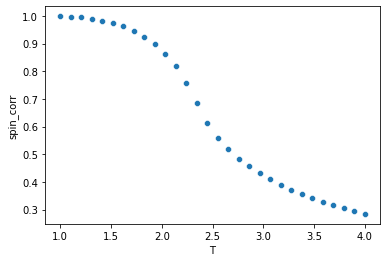

In [62]:
df = pd.DataFrame([{"T": el["T"], "spin_corr": el["res"][-1]["spin_corr"]} for el in res0_li])
sns.scatterplot(data=df, x="T", y="spin_corr")

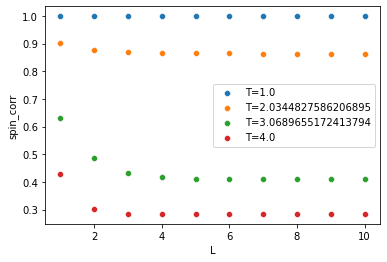

In [63]:
for el in res0_li[::10] + [res0_li[-1]]:
    T = el["T"]
    df = pd.DataFrame(el["res"])
    sns.scatterplot(data=df, x="L", y="spin_corr", label=f"T={T}")

どの温度でも十分に早い速度で収束している。臨界点温度を調べる。

In [46]:
T = 2.27
ctmrg = CTMRG(
    N=20,
    J_kT=1.0/T,
    chi=None,
    boundary_cond="fixed",
    rescale=True)
res = ctmrg.run_directory()

In [56]:
x = tf.constant([1, 2, 3])
tf.linalg.diag(x)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]], dtype=int32)>

In [55]:
m = tf.constant([[1.0, 2.0, 3.0], [2.0, 5.0, 4.0], [3.0, 4.0, 6.0]])
lam_w = tf.linalg.eigh(m)[0]
display(lam_w)
nw = 2
display(lam_w[len(lam_w)-nw:])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.40972495,  1.5771484 , 10.832573  ], dtype=float32)>

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.5771484, 10.832573 ], dtype=float32)>

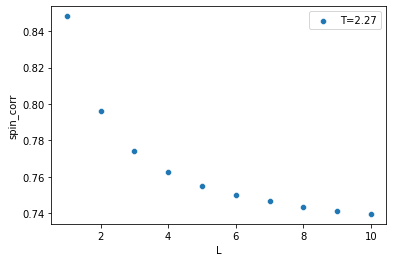

In [48]:
df = pd.DataFrame(res)
sns.scatterplot(data=df, x="L", y="spin_corr", label=f"T={T}")

他の温度に比べて収束が遅くなる。これは、TCRMGを使わないと正しく素早く収束計算できないかも。

In [71]:
from time import time
t0 = time()
T = 2.27
ctmrg = CTMRG(
    N=20,
    J_kT=1.0/T,
    chi=None,
    boundary_cond="fixed",
    rescale=True)
res_chi100 = ctmrg.run()
t1 = time()
print("elapsed time:", t1-t0)

elapsed time: 2.4313416481018066


In [72]:
t0 = time()
chi = 100
T = 2.27
ctmrg = CTMRG(
    N=30,
    J_kT=1.0/T,
    chi=chi,
    boundary_cond="fixed",
    rescale=True)
res_chi100 = ctmrg.run()
t1 = time()
print("elapsed time:", t1-t0)

elapsed time: 0.10281896591186523


CTMRGを使うことで相当な計算速度向上

In [79]:
t0 = time()
chi = 100
T = 2.27
ctmrg = CTMRG(
    N=1000,
    J_kT=1.0/T,
    chi=chi,
    boundary_cond="fixed",
    rescale=True)
res_chi100 = ctmrg.run()
t1 = time()
print("elapsed time:", t1-t0)

elapsed time: 3.048804759979248


In [84]:
t0 = time()
chi = 4
T = 2.27
ctmrg = CTMRG(
    N=1000,
    J_kT=1.0/T,
    chi=chi,
    boundary_cond="fixed",
    rescale=True)
res_chi4 = ctmrg.run()
t1 = time()
print("elapsed time:", t1-t0)

elapsed time: 0.9904189109802246


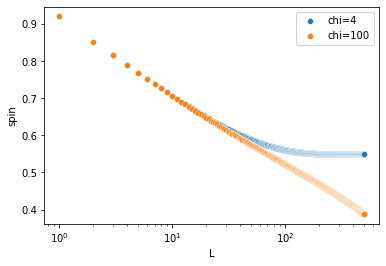

In [85]:
df = pd.DataFrame(res_chi4)
sns.scatterplot(data=df, x="L", y="spin", label="chi=4")
df = pd.DataFrame(res_chi100)
sns.scatterplot(data=df, x="L", y="spin", label="chi=100")
plt.xscale("log")